In [1]:
# RNN - US Airline Sentiment Analysis using RNN
# A Recurrent Neural Network (RNN) is a class of artificial neural networks where connections between nodes form 
# a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. 
# Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs.

In [ ]:
#Fruit fly: 100 thousand neurons
#Cockroach: One million neurons
#Mouse: 75 million neurons
#Cat: One billion neurons
#Chimpanzee: 7 billion neurons
#Elephant: 23 billion neurons
#Human: 86 billion neurons

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os
print(os.listdir("E:/SentimentAnalysis"))

['database.sqlite', 'trainingandtestdata.zip', 'Tweets.csv', 'twitter-airline-sentiment.zip']


In [5]:
# # Any results I write to the current directory are saved as output.

In [8]:
import re # Python's built-in "re" module provides excellent support for regular expressions

In [9]:
# IMPORT Keras models and the layers, processing and utils.
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
np.random.seed(1)
from sklearn.model_selection import train_test_split  # Scikit-learn is a library in Python that provides 
                                                      # many unsupervised and supervised learning algorithms

Using TensorFlow backend.


In [10]:
#from emo_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def remove_stopwords(input_text):
    '''
    Data Preparation:
    Function to remove English stopwords from a Pandas Series.
        Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
        Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [14]:
# Read the input data
#Read the data
train_df = pd.read_csv("E:/SentimentAnalysis/Tweets.csv")
train_df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [15]:
#check Different labels for Sentiment
Mood = train_df['airline_sentiment'].value_counts()

In [16]:
Mood

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0.5, 1.0, 'Mood Distribution')

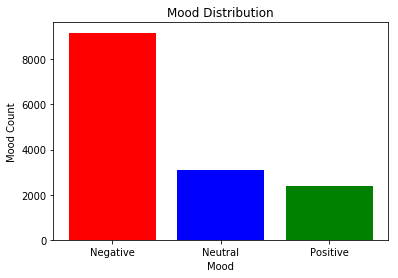

In [17]:
index = [1,2,3]
plt.bar(index,Mood,color=['r','b','g'])
plt.xticks(index,['Negative','Neutral','Positive'])
plt.xlabel('Mood')
plt.ylabel('Mood Count')
plt.title('Mood Distribution')

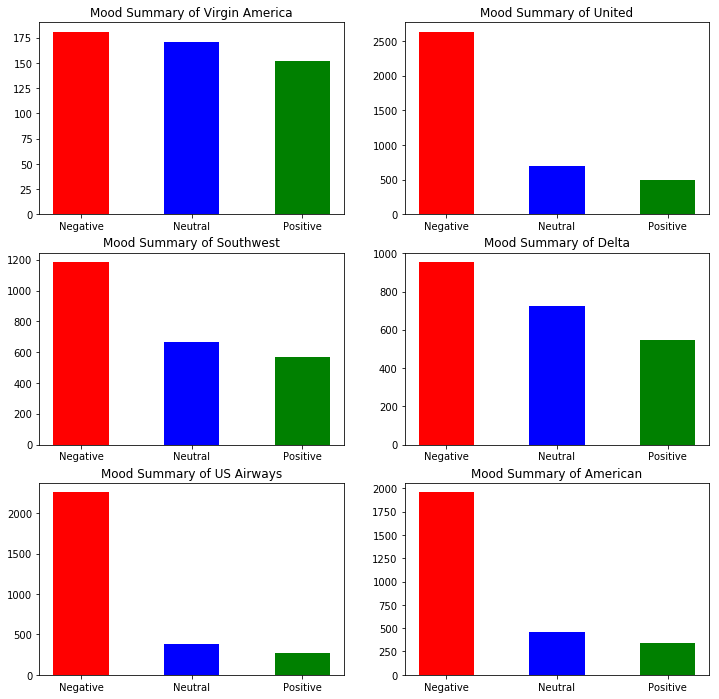

In [18]:
# Plot the sentiment for each eariline (6 Aairlines in US). The classification : Negative, Neutral and Positive
def plot_sub_sentiment(Airline):
    pdf = train_df[train_df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color = ['red','blue','green']
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Mood Summary of' + " " + Airline)

airline_name = train_df['airline'].unique()
plt.figure(1,figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])
plt.show()

In [19]:
#cleaning Data to remove mentions
train_df = train_df[['text', 'airline_sentiment']]
train_df.text = train_df.text.apply(remove_mentions)
train_df.loc[:,'sentiment'] = train_df.airline_sentiment.map({'negative':0,'neutral':1,'positive':2})
train_df = train_df.drop(['airline_sentiment'], axis=1)
train_df.head()

,text,sentiment
0,What said.,1
1,plus you've added commercials to the experien...,2
2,I didn't today... Must mean I need to take an...,1
3,"it's really aggressive to blast obnoxious ""en...",0
4,and it's a really big bad thing about it,0


In [20]:
#Now I will find the maximun length of the input string so as to fed the neural net with same length
raw_docs_train = train_df["text"].values
sentiment_train = train_df['sentiment'].values

maxLen = len(max(raw_docs_train, key=len).split())

In [21]:
maxLen

26

In [22]:
#For RNN model, need to split the training dataset into test dataset. This is actually dev set for getting the loss
# test size is 20%
# train size is 80%
X_train, X_test, Y_train, Y_test = train_test_split(raw_docs_train, sentiment_train, 
                                                    stratify=sentiment_train, 
                                                    random_state=42, 
                                                    test_size=0.2, shuffle=True)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

# Train data samples: (11712,)
# Test data samples: (2928,)


In [23]:
#Convert the labels to Onehot encoding vector for 'softmax' neural network

#Y_oh_train = convert_to_one_hot(Y_train, C = num_labels)
num_labels = len(np.unique(sentiment_train))
Y_oh_train = np_utils.to_categorical(Y_train, num_labels)
Y_oh_test = np_utils.to_categorical(Y_test, num_labels)
print(Y_oh_train.shape)

(11712, 3)


In [26]:
#Now we need Glove Vectors for Words which is available online  (Kaggle download 69mb zip file)
#word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('Data/glove.6B.50d.txt')

# load the GloVe vectors in a dictionary: from Kaggle - https://www.kaggle.com/watts2/glove6b50dtxt

def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('E:/SentimentAnalysis/glove.6B.50d.txt')

In [43]:
# TO get the index of a word and the word for an index from GloVe DB:
# so this GloVe data base has indices for each word in the text file.
word = "cat"
index = 57797
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cat in the vocabulary is 93522
the 57797th word in the vocabulary is apple


In [44]:
# This function convert array of strings into array of Indices of word in the voacab.

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =[word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except: 0
            # Increment j to j + 1
            j = j+1
    
    return X_indices

In [45]:
# Create Keras Embedding layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [46]:
def ltsm_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the ltsm_model model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices =  Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(3, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [47]:
model = ltsm_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 26, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)  

In [48]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
print(X_train_indices.shape)

(11712, 26)


In [50]:
# Early stopping is basically stopping the training once your loss starts to increase 
#       (or in other words validation accuracy starts to decrease).
# You can use callbacks to get a view on internal states and statistics of the model during training. 

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(X_train_indices, y=Y_oh_train, batch_size=512, epochs=20, 
          verbose=1, validation_data=(X_test_indices, Y_oh_test), callbacks=[earlystop])

Instructions for updating:
Use tf.cast instead.
Train on 11712 samples, validate on 2928 samples
Epoch 1/20
11712/11712 [==============================] - 14s 1ms/step - loss: 0.8746 - acc: 0.6179 - val_loss: 0.8322 - val_acc: 0.6270
Epoch 2/20
11712/11712 [==============================] - 8s 695us/step - loss: 0.8112 - acc: 0.6508 - val_loss: 0.7452 - val_acc: 0.6950
Epoch 3/20
11712/11712 [==============================] - 9s 746us/step - loss: 0.7268 - acc: 0.7025 - val_loss: 0.7024 - val_acc: 0.7220
Epoch 4/20
11712/11712 [==============================] - 8s 688us/step - loss: 0.6813 - acc: 0.7211 - val_loss: 0.6639 - val_acc: 0.7281
Epoch 5/20
11712/11712 [==============================] - 9s 736us/step - loss: 0.6672 - acc: 0.7283 - val_loss: 0.6481 - val_acc: 0.7370
Epoch 6/20
11712/11712 [==============================] - 8s 690us/step - loss: 0.6473 - acc: 0.7328 - val_loss: 0.6497 - val_acc: 0.7370
Epoch 7/20
11712/11712 [==============================] - 9s 758us/step - lo

In [ ]:
# This nodel has
# Validation/Training accuracy of 74.25%
# Testing accuracy if 77.54%

In [59]:
#Check Prediction for a particular example
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings. 

#  'negative':0,'neutral':1,'positive':2

x_test = np.array(['good customer service'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' : '+  str(np.argmax(model.predict(X_test_indices))))

good customer service : 2


In [58]:
#Check Prediction for an example from the data we saw in above steps. 
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  

#  'negative':0,'neutral':1,'positive':2

x_test = np.array(['and its a really big bad thing about it'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' : '+  str(np.argmax(model.predict(X_test_indices))))

and its a really big bad thing about it : 0


In [57]:
#Check Prediction for an example from the data we saw in above steps. 
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  

#  'negative':0,'neutral':1,'positive':2

x_test = np.array(['Must mean I need to take an'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' : '+  str(np.argmax(model.predict(X_test_indices))))

Must mean I need to take an : 1


In [60]:
# The above model has a good accuracy of 78% using RNN